In [1]:
from pathlib import Path
import pandas as pd

# -----------------------------
# Resolve project root safely
# -----------------------------
BASE_DIR = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# -----------------------------
# Define paths
# -----------------------------
RAW_PATH = BASE_DIR / "data" / "raw" / "creditcard.csv"
IFOREST_PATH = BASE_DIR / "data" / "processed" / "iforest_scores.csv"
AE_PATH = BASE_DIR / "data" / "processed" / "ae_scores.csv"

# -----------------------------
# Optional safety checks
# -----------------------------
assert RAW_PATH.exists(), f"Missing raw data file: {RAW_PATH}"
assert IFOREST_PATH.exists(), f"Missing iForest scores file: {IFOREST_PATH}"
assert AE_PATH.exists(), f"Missing autoencoder scores file: {AE_PATH}"

# -----------------------------
# Load data
# -----------------------------
# Original fraud labels
raw = pd.read_csv(RAW_PATH, usecols=["is_fraud"])
labels = raw["is_fraud"]

# Model scores
if_df = pd.read_csv(IFOREST_PATH)
ae_df = pd.read_csv(AE_PATH)

# -----------------------------
# Combine scores and labels for comparison
# -----------------------------
scores = pd.DataFrame({
    "if_score": if_df["anomaly_score"],
    "ae_score": ae_df["ae_score"],
    "label": labels
})


In [2]:
eval_df = pd.DataFrame({
    "label": raw["is_fraud"],
    "if_score": if_df["anomaly_score"],
    "ae_score": ae_df["ae_score"]
})


In [3]:
eval_df["label"].mean()


np.float64(0.005788651743883394)

In [4]:
import numpy as np

alert_rates = [0.005, 0.01, 0.02]


In [5]:
def precision_at_k(scores, labels, rate):
    threshold = np.percentile(scores, 100 * (1 - rate))
    preds = scores >= threshold
    return labels[preds].mean()


In [6]:
results = []

for rate in alert_rates:
    results.append({
        "alert_rate": rate,
        "model": "IsolationForest",
        "precision_at_k": precision_at_k(
            eval_df["if_score"].values,
            eval_df["label"].values,
            rate
        )
    })
    results.append({
        "alert_rate": rate,
        "model": "Autoencoder",
        "precision_at_k": precision_at_k(
            eval_df["ae_score"].values,
            eval_df["label"].values,
            rate
        )
    })

precision_df = pd.DataFrame(results)
precision_df


,alert_rate,model,precision_at_k
0,0.005,IsolationForest,0.006169
1,0.005,Autoencoder,0.005861
2,0.010,IsolationForest,0.006401
3,0.010,Autoencoder,0.006247
4,0.020,IsolationForest,0.006285
5,0.020,Autoencoder,0.005630


In [7]:
def recall_at_k(scores, labels, rate):
    threshold = np.percentile(scores, 100 * (1 - rate))
    preds = scores >= threshold
    return labels[preds].sum() / labels.sum()


In [8]:
results = []

for rate in alert_rates:
    results.append({
        "alert_rate": rate,
        "model": "IsolationForest",
        "recall_at_k": recall_at_k(
            eval_df["if_score"].values,
            eval_df["label"].values,
            rate
        )
    })
    results.append({
        "alert_rate": rate,
        "model": "Autoencoder",
        "recall_at_k": recall_at_k(
            eval_df["ae_score"].values,
            eval_df["label"].values,
            rate
        )
    })

recall_df = pd.DataFrame(results)
recall_df


,alert_rate,model,recall_at_k
0,0.005,IsolationForest,0.005329
1,0.005,Autoencoder,0.005063
2,0.010,IsolationForest,0.011058
3,0.010,Autoencoder,0.010791
4,0.020,IsolationForest,0.021716
5,0.020,Autoencoder,0.019451


In [9]:
from sklearn.metrics import roc_auc_score

roc_results = {
    "IsolationForest": roc_auc_score(eval_df["label"], eval_df["if_score"]),
    "Autoencoder": roc_auc_score(eval_df["label"], eval_df["ae_score"])
}

roc_results


{'IsolationForest': 0.5006937096322033, 'Autoencoder': 0.4954634274174488}

In [10]:
final_metrics = precision_df.merge(
    recall_df,
    on=["model", "alert_rate"]
)

final_metrics


,alert_rate,model,precision_at_k,recall_at_k
0,0.005,IsolationForest,0.006169,0.005329
1,0.005,Autoencoder,0.005861,0.005063
2,0.010,IsolationForest,0.006401,0.011058
3,0.010,Autoencoder,0.006247,0.010791
4,0.020,IsolationForest,0.006285,0.021716
5,0.020,Autoencoder,0.005630,0.019451


In [11]:
eval_df = eval_df.copy()

In [12]:
alert_rates = np.linspace(0.002, 0.03, 10)  # 0.2% → 3%


In [13]:
def compute_cost(scores, labels, rate, cost_review, cost_fraud):
    threshold = np.percentile(scores, 100 * (1 - rate))
    alerts = scores >= threshold

    TP = ((alerts == 1) & (labels == 1)).sum()
    FP = ((alerts == 1) & (labels == 0)).sum()
    FN = ((alerts == 0) & (labels == 1)).sum()

    total_cost = FP * cost_review + FN * cost_fraud

    return {
        "alert_rate": rate,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "total_cost": total_cost
    }


In [14]:
C_REVIEW = 5
C_FRAUD = 500

cost_results = []

for rate in alert_rates:
    cost_results.append(
        compute_cost(
            eval_df["if_score"].values,
            eval_df["label"].values,
            rate,
            C_REVIEW,
            C_FRAUD
        )
    )

cost_df = pd.DataFrame(cost_results)
cost_df


,alert_rate,TP,FP,FN,total_cost
0,0.002000,17,2577,7489,3757385
1,0.005111,42,6586,7464,3764930
2,0.008222,65,10597,7441,3773485
3,0.011333,97,14599,7409,3777495
4,0.014444,118,18612,7388,3787060
5,0.017556,146,22618,7360,3793090
6,0.020667,168,26630,7338,3802150
7,0.023778,186,30647,7320,3813235
8,0.026889,213,34654,7293,3819770
9,0.030000,248,38653,7258,3822265


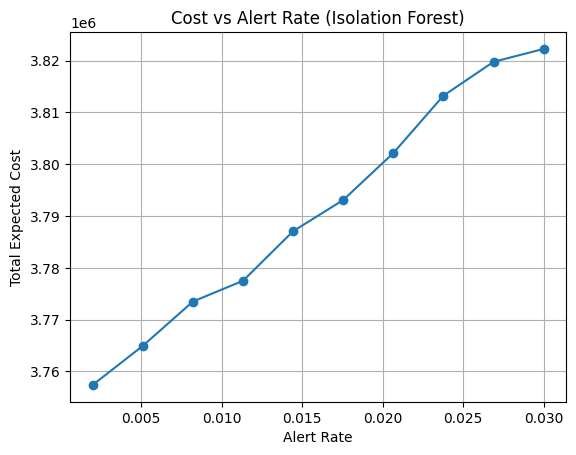

In [15]:
import matplotlib.pyplot as plt

plt.plot(cost_df["alert_rate"], cost_df["total_cost"], marker="o")
plt.xlabel("Alert Rate")
plt.ylabel("Total Expected Cost")
plt.title("Cost vs Alert Rate (Isolation Forest)")
plt.grid(True)
plt.show()


In [16]:
optimal = cost_df.loc[cost_df["total_cost"].idxmin()]
optimal


alert_rate          0.002
TP                 17.000
FP               2577.000
FN               7489.000
total_cost    3757385.000
Name: 0, dtype: float64

In [17]:
for c_fraud in [300, 500, 1000]:
    cost_df[f"cost_fraud_{c_fraud}"] = [
        compute_cost(
            eval_df["if_score"].values,
            eval_df["label"].values,
            rate,
            C_REVIEW,
            c_fraud
        )["total_cost"]
        for rate in alert_rates
    ]
